<a href="https://colab.research.google.com/github/ohmji/cnn-facial-expression-transfer-learning/blob/main/facial_expression_with_mobilev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Train

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dropout, \
    Flatten, Dense, BatchNormalization, \
    SpatialDropout2D, AveragePooling2D, Input, GlobalAveragePooling2D, Activation, ZeroPadding2D, Convolution2D
import os
import cv2
import warnings
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from sklearn import model_selection

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')

In [3]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.get_logger().setLevel('WARNING')

In [6]:
def MobileNetV2_model(learning_rate, input_shape):
    baseModel = MobileNetV2(
        # include_top=False,
        # weights='imagenet',
        input_tensor=Input(shape=input_shape)
    )

    base_input = baseModel.layers[0].input
    base_output = baseModel.layers[-2].output
    
    # gbAverage = layers.GlobalAveragePooling2D(1280)(base_output)
    final_output = layers.Dense(128)(base_output)
    final_ouput  = layers.Activation('relu')(final_output)
    final_output = layers.Dense(64)(final_ouput)
    final_ouput =  layers.Activation('relu')(final_output)
    final_output = layers.Dense(7, activation='softmax')(final_ouput)
    # model.add(baseModel)
    # for layer in baseModel.layers[:-2]:
    #     layer.trainable = False

    # model.add(Flatten())
    # model.add(Dense(2560, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(1280, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(7, activation='softmax'))
    model = Model(inputs=base_input,outputs = final_output)
    model.compile(loss="binary_crossentropy", metrics=["accuracy"],
                  optimizer=Adam(learning_rate=learning_rate))
    return model

In [7]:
def keras_model_memory_usage_in_bytes(model, *, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    Ref: https://stackoverflow.com/a/64359137
    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size)
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum([tf.keras.backend.count_params(p)
                           for p in model.trainable_weights])
    non_trainable_count = sum([tf.keras.backend.count_params(p)
                               for p in model.non_trainable_weights])

    total_memory = (batch_size * shapes_mem_count + internal_model_mem_count
                    + trainable_count + non_trainable_count)
    return total_memory


In [8]:
def preprocess_data(data,labels):
    

    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    n_samples = len(data)
    w = 64
    h = 64
    y = np.array(labels[orig_class_names])
    X = np.zeros((n_samples, w, h, 3))
    for i in range(n_samples):
        image = np.fromstring(data['pixels'][i], dtype=int,
                              sep=' ').reshape((48, 48, 1))
      
        image48_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(image))
        X[i]=  cv2.resize(np.float32(image48_rgb),(64,64))

    return X, y

In [9]:
def clean_data_and_normalize(X, y):
    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    # Using mask to remove unknown or NF images
    y_mask = y.argmax(axis=-1)
    mask = y_mask < orig_class_names.index('unknown')
    X = X[mask]
    y = y[mask]
    # np.save('/content/drive/MyDrive/colab/dataset_np1.npy',X)

    # Convert to probabilities between 0 and 1
    y = y[:, :-2] * 0.1

    # Add contempt to neutral and remove it
    y[:, 0] += y[:, 7]
    y = y[:, :7]

    # Normalize image vectors
    X = X / 255.0

    return X, y

In [10]:
def split_data(X, y):
    test_size = ceil(len(X) * 0.1)

    # Split Data
    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=test_size,
                                                                      random_state=42)
    return x_train, y_train, x_val, y_val, x_test, y_test

def data_augmentation(x_train):
    shift = 0.1
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        height_shift_range=shift,
        width_shift_range=shift)
    datagen.fit(x_train)
    return datagen

In [11]:
bs = 64
lr = 0.0001
size = (64, 64)
shape = (64,64, 3)
epochs = 100


In [12]:

fileSave = "facial_expression.model"
data = pd.read_csv('/content/drive/MyDrive/colab/fer2013.csv')
labels = pd.read_csv('/content/drive/MyDrive/colab/fer2013new.csv')
print(data)
print(labels)


       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]
             Usage      Im

In [13]:
X, y = preprocess_data(data,labels)
X, y = clean_data_and_normalize(X, y)
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)
datagen = data_augmentation(x_train)

In [14]:
net_type_to_model = {
        'MB2': MobileNetV2_model,
    }
model_name ="MB2"
model_builder = net_type_to_model.get(model_name)
model = model_builder(lr, shape)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 32, 32, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [15]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, mode='auto')
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
checkpoint = ModelCheckpoint(os.path.join("results", f"{model_name}" + f"-size-{size[0]}" +
                                              f"-bs-{bs}" + f"-lr-{lr}.h5"),
                                 monitor='val_loss', save_best_only=True, verbose=1)


In [16]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=bs), epochs=epochs,
                        steps_per_epoch=len(x_train) // bs,
                        batch_size=bs, callbacks=[
        earlystop, tensorboard, checkpoint], shuffle=True,
        validation_data=(x_val, y_val), verbose=2)
print(history)

Epoch 1/100
443/443 - 40s - loss: 0.3581 - accuracy: 0.4675 - val_loss: 0.6240 - val_accuracy: 0.4717

Epoch 00001: val_loss improved from inf to 0.62399, saving model to results/MB2-size-64-bs-64-lr-0.0001.h5
Epoch 2/100
443/443 - 32s - loss: 0.2758 - accuracy: 0.6215 - val_loss: 0.6247 - val_accuracy: 0.5404

Epoch 00002: val_loss did not improve from 0.62399
Epoch 3/100
443/443 - 32s - loss: 0.2563 - accuracy: 0.6642 - val_loss: 0.4252 - val_accuracy: 0.6086

Epoch 00003: val_loss improved from 0.62399 to 0.42521, saving model to results/MB2-size-64-bs-64-lr-0.0001.h5
Epoch 4/100
443/443 - 32s - loss: 0.2431 - accuracy: 0.6958 - val_loss: 0.3420 - val_accuracy: 0.6624

Epoch 00004: val_loss improved from 0.42521 to 0.34199, saving model to results/MB2-size-64-bs-64-lr-0.0001.h5
Epoch 5/100
443/443 - 32s - loss: 0.2338 - accuracy: 0.7169 - val_loss: 0.2786 - val_accuracy: 0.6996

Epoch 00005: val_loss improved from 0.34199 to 0.27859, saving model to results/MB2-size-64-bs-64-lr-0.00

In [17]:
test_loss, test_accuracy = model.evaluate(
        x_test, y_test, batch_size=bs)
metrics = pd.DataFrame(history.history)

56/56 [==============================] - 1s 10ms/step - loss: 0.1985 - accuracy: 0.8064


In [18]:
print(metrics.head(10))

print('test_loss: ', test_loss)
print('test_accuracy: ', test_accuracy)
print('Memory consumption: %s bytes' %
          keras_model_memory_usage_in_bytes(model, batch_size=bs))

    # save_model_and_weights(model, test_accuracy)
model.save('/content/drive/MyDrive/colab/model/'+model_name+'_'+fileSave, save_format="h5")

       loss  accuracy  val_loss  val_accuracy
0  0.358096  0.467450  0.623986      0.471682
1  0.275766  0.621514  0.624694      0.540434
2  0.256344  0.664195  0.425208      0.608622
3  0.243149  0.695827  0.341987      0.662440
4  0.233766  0.716868  0.278595      0.699634
5  0.226226  0.734414  0.256523      0.710623
6  0.220729  0.747158  0.251844      0.730065
7  0.215539  0.761562  0.244000      0.741054
8  0.212064  0.768658  0.225106      0.763595
9  0.208503  0.777625  0.217962      0.777684
test_loss:  0.19845260679721832
test_accuracy:  0.8064243197441101
Memory consumption: 462327239 bytes


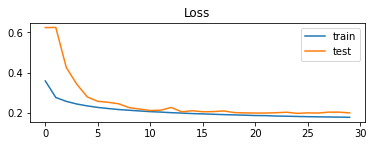

In [19]:

plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

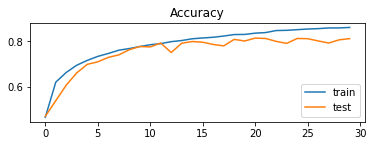

In [20]:
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

## Test Model

In [21]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from keras.preprocessing import image
import random
import string

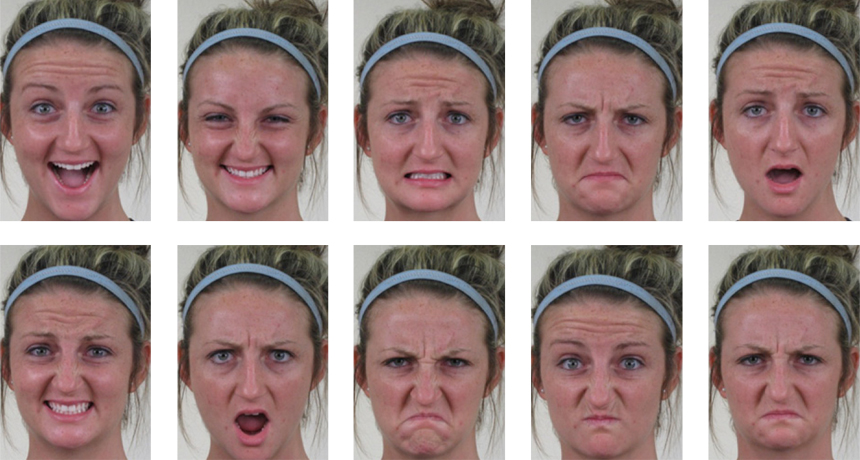

In [38]:
modelPath ="/content/drive/MyDrive/colab/model/MB2_facial_expression.model"
imagePath ="/content/drive/MyDrive/colab/data/original.jpg"
# prototxtPath = os.path.sep.join(["/content/drive/MyDrive/colab/face_detector/", "deploy.prototxt"])
# weightsPath = os.path.sep.join(
#         ["/content/drive/MyDrive/colab/face_detector/haarcascade_frontalface_default.xml"])
classifier = cv2.CascadeClassifier("/content/drive/MyDrive/colab/face_detector/haarcascade_frontalface_default.xml")

    # load the face mask detector model from disk
model = load_model(modelPath)
img = cv2.imread(imagePath)
cv2_imshow(img)

In [39]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
faces_detected = classifier.detectMultiScale(gray_img, 1.18, 5)


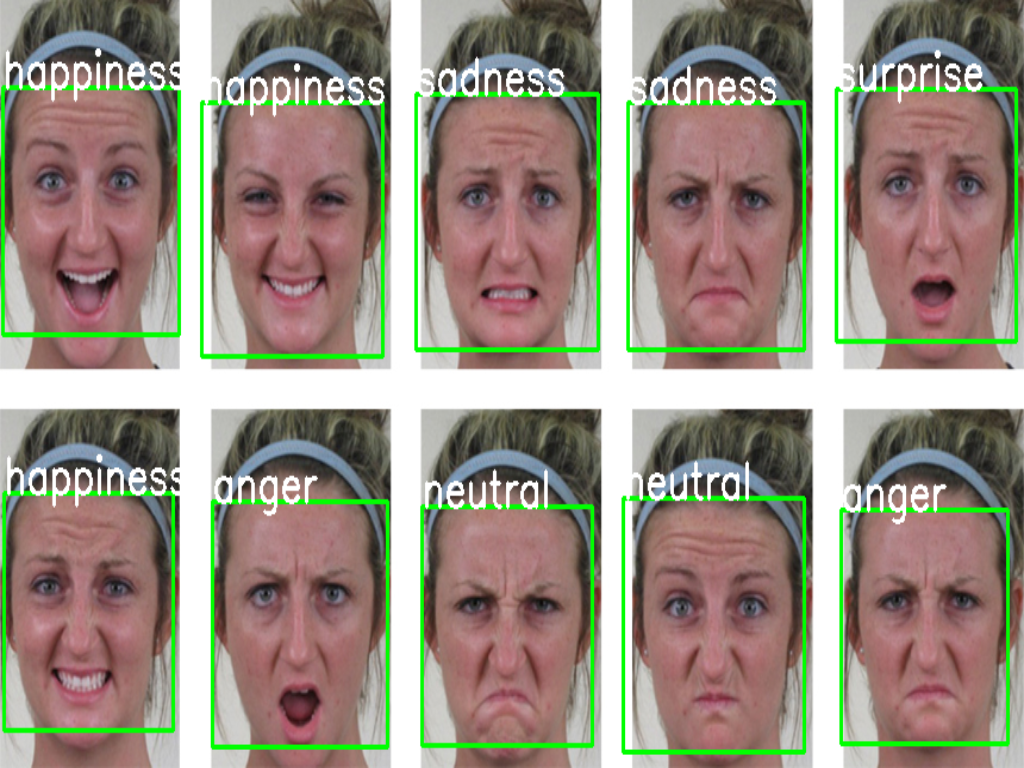

In [41]:
for (x, y, w, h) in faces_detected:
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    roi_gray = gray_img[y:y + w, x:x + h]
    roi_gray = cv2.resize(roi_gray, (64, 64))
    img_pixels = image.img_to_array(roi_gray)
    img_pixels = np.expand_dims(img_pixels, axis=0)
    img_pixels /= 255.0

    predictions = model.predict(img_pixels)
    max_index = int(np.argmax(predictions))
    # print(max_index)
    emotions = ['neutral', 'happiness', 'surprise',
                'sadness', 'anger', 'disgust', 'fear']
    predicted_emotion = emotions[max_index]

    cv2.putText(img, predicted_emotion, (int(x), int(y)),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

resized_img = cv2.resize(img, (1024, 768))

cv2_imshow(resized_img)
